In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/MyDrive/mniscnn")
!pip install dipy healpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys
import time

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns
import torch

from mniscnn import (
    compartment_model_simulation,
    isft,
    l_max,
    n_coeffs,
    sft,
    sh,
)

sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a2bcd4c5-d8e1-ac0f-df3c-5df76f84009b)


In [4]:
# Define acquisition protocol

bvals = torch.tensor(np.loadtxt("data/train-subject/dwi.bval") / 1e3)
bvecs = torch.tensor(np.loadtxt("data/train-subject/dwi.bvec").T)

idx = bvals > 0
bvals = bvals[idx]
bvecs = bvecs[idx]

bs = torch.unique(bvals)
n_shells = len(bs)
shell_idx_list = [np.where(bvals == b)[0] for b in bs]
bvecs_list = [bvecs[bvals == b] for b in bs]

bvecs_sft_list = []
bvecs_isft_list = []
for bvecs in bvecs_list:
    thetas = np.arccos(bvecs[:, 2])
    phis = np.arctan2(bvecs[:, 1], bvecs[:, 0]) + np.pi
    bvecs_isft = np.zeros((len(bvecs), n_coeffs))
    for l in range(0, l_max + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = sh(l, m, thetas, phis)
    bvecs_sft = np.linalg.inv(bvecs_isft.T @ bvecs_isft) @ bvecs_isft.T
    bvecs_sft_list.append(torch.tensor(bvecs_sft).float())
    bvecs_isft_list.append(torch.tensor(bvecs_isft).float())

In [5]:
# Define model


class MLPModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 256)
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.fc4 = torch.nn.Linear(256, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.nn.functional.relu(x)
        x = self.fc4(x)
        return x


torch.random.manual_seed(123)
model = MLPModel().to(device)

print(f"Number of trainable parameters = {sum(p.numel() for p in model.parameters())}")

Number of trainable parameters = 134402


In [6]:
# Define validation dataset

SNR = 30
n_val = int(1e5)
n_iter = int(1e4)

torch.random.manual_seed(123)
val_ds = torch.rand(n_val) * 3
val_fs = torch.rand(n_val)
val_odfs_sh = torch.tensor(np.loadtxt("data/val-subject/odfs_sh.txt")).float()
np.random.seed(123)
val_odfs_sh = val_odfs_sh[np.random.choice(len(val_odfs_sh), n_val)]

val_targets = torch.vstack((val_ds / 3, val_fs)).T
val_signals = torch.zeros(n_val, n_shells)

for i in range(0, n_val, n_iter):

    idx = torch.arange(i, i + n_iter)

    batch_ads = torch.vstack((val_ds[idx], val_ds[idx])).T
    batch_rds = torch.vstack(
        (
            torch.zeros(len(idx)),
            (1 - val_fs[idx]) * val_ds[idx],
        )
    ).T
    batch_fs = torch.vstack((val_fs[idx], 1 - val_fs[idx])).T
    batch_odfs_sh = val_odfs_sh[idx]

    for j, b in enumerate(bs):
        signals = compartment_model_simulation(
            b,
            bvecs_isft_list[j],
            batch_ads,
            batch_rds,
            batch_fs,
            batch_odfs_sh,
            "linear",
            device,
        ).cpu()
        signals = torch.abs(
            signals
            + torch.normal(
                mean=torch.zeros(signals.size()),
                std=torch.ones(signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(signals.size()),
                std=torch.ones(signals.size()) / SNR,
            )
        )
        val_signals[idx, j] = torch.mean(signals.squeeze(-1), dim=1)

val_loss = 0.007315787021070719
training took 0.49 h


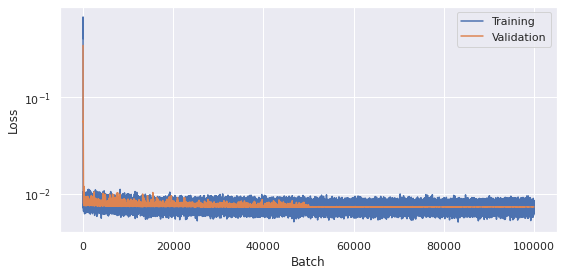

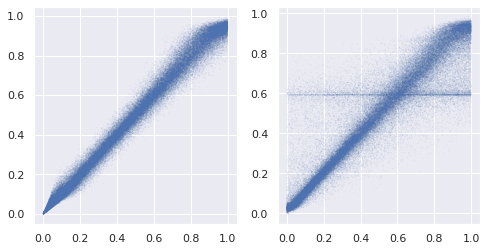

In [ ]:
# Train

batch_size = int(1e3)
n_batches = int(1e5)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_odfs_sh = torch.tensor(np.loadtxt("data/train-subject/odfs_sh.txt")).float()
Rs = torch.tensor(
    np.concatenate(
        (
            np.eye(45)[np.newaxis],
            np.load("data/train-subject/Rs.npy").reshape(-1, n_coeffs, n_coeffs),
        ),
        axis=0,
    )
).float()

train_losses = []
val_losses = []

start_time = time.time()

for batch in range(n_batches):

    if batch == int(5e4) or batch == int(7.5e4):
        scheduler.step()

    torch.random.manual_seed(batch)
    random_ds = torch.rand(batch_size) * 3
    random_fs = torch.rand(batch_size)

    batch_targets = torch.vstack((random_ds / 3, random_fs)).T

    np.random.seed(batch)
    batch_odfs_sh = train_odfs_sh[np.random.choice(len(train_odfs_sh), batch_size)]
    batch_Rs = Rs[np.random.choice(len(Rs), batch_size)]
    batch_odfs_sh = (batch_Rs @ batch_odfs_sh.unsqueeze(-1)).squeeze(-1)

    batch_ads = torch.vstack((random_ds, random_ds)).T
    batch_rds = torch.vstack(
        (
            torch.zeros(batch_size),
            (1 - random_fs) * random_ds,
        )
    ).T
    batch_fs = torch.vstack((random_fs, 1 - random_fs)).T

    signals = torch.zeros(batch_size, n_shells)
    for j, b in enumerate(bs):
        shell_signals = (
            compartment_model_simulation(
                b,
                bvecs_isft_list[j],
                batch_ads,
                batch_rds,
                batch_fs,
                batch_odfs_sh,
                "linear",
                device,
            )
            .cpu()
            .squeeze(-1)
        )
        shell_signals = torch.abs(
            shell_signals
            + torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
        )
        signals[:, j] = torch.mean(shell_signals.squeeze(-1), dim=1)

    y = model(signals.to(device))
    loss = loss_fn(y, batch_targets.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item())

    if batch % 10 == 0 or batch == n_batches - 1:
        model.eval()
        with torch.no_grad():
            val_preds = torch.zeros(val_targets.size()).to(device)
            for i in range(0, n_val, n_iter):
                idx = torch.arange(i, i + n_iter)
                val_preds[idx] = model(val_signals[idx].to(device))
            val_losses.append(loss_fn(val_preds, val_targets.to(device)).item())
        model.train()

    sys.stdout.write(
        f"\rbatch = {batch + 1}, train loss = {train_losses[-1]}, val loss = {val_losses[-1]}"
    )
    sys.stdout.flush()

sys.stdout.write(f"\rval_loss = {val_losses[-1]}\n")
sys.stdout.flush()

print(f"training took {np.round((time.time() - start_time) / 60 ** 2, 2)} h")

fig = plt.figure(figsize=(8, 4))
plt.plot(np.linspace(1, n_batches, n_batches), train_losses)
plt.plot(np.linspace(1, n_batches, len(val_losses)), val_losses)
plt.yscale("log")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    sc = ax[i].scatter(val_targets[:, i], val_preds[:, i].cpu(), s=1, alpha=0.1)
    sc.set_edgecolor("none")
plt.show()

torch.save(model.state_dict(), "mlp_model_weights.pt")
np.savetxt("mlp_train_losses.txt", train_losses)
np.savetxt("mlp_val_losses.txt", val_losses)